# 0) Work Directory and setup

In [1]:
import os
# Obtiene el nuevo directorio actual después del cambio
new_directory = '/Users/jyoung/Doctorado/embryo_classification/'
os.chdir(new_directory)
print("New actual directory:", new_directory)

# Elimino warnings molestas
import warnings
warnings.filterwarnings("ignore")

New actual directory: /Users/jyoung/Doctorado/embryo_classification/


# 1) Libraries

In [2]:
# Data Manipulation and Visualization
import numpy as np                  # NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt     # Matplotlib for creating visualizations
from pathlib import Path            # Pathlib for working with file paths
import openpyxl                     # Openpyxl for reading and writing Excel files
import json                         # JSON for data serialization
from tqdm import tqdm               # tqdm for creating progress bars
from typing import Tuple, List, Union  # Typing for type hinting in function signatures

# Model Training and Evaluation
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold  # Hyperparameter tuning and cross-validation
from sklearn.tree import DecisionTreeClassifier  # DecisionTreeClassifier for tree-based models
from sklearn.ensemble import RandomForestClassifier  # RandomForestClassifier for ensemble learning
from sklearn.metrics import confusion_matrix, accuracy_score  # Metrics for model evaluation
from sklearn.svm import SVC          # Support Vector Classification
from sklearn.neural_network import MLPClassifier  # Multi-layer Perceptron classifier
import xgboost as xgb               # XGBoost for gradient boosting
from sklearn.naive_bayes import GaussianNB  # Gaussian Naive Bayes classifier
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction
from sklearn.model_selection import train_test_split  # Splitting data for training and testing
from xgboost import plot_tree       # Plotting decision trees in XGBoost
from sklearn.model_selection import cross_val_score  # Cross-validation for model evaluation
from sklearn.model_selection import KFold  # K-Fold cross-validation

# Image Processing and Feature Extraction
from skimage.feature import graycomatrix, graycoprops  # Image texture features using co-occurrence matrix
from skimage import exposure         # Image exposure adjustment
from scipy import ndimage            # Multi-dimensional image processing
import skimage.measure              # Image measurement and analysis
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # Image preprocessing using Keras
from PIL import Image

# Deep learning tools
import torch  # PyTorch library
from skimage.transform import resize  # skimage library for image resizing
from tensorflow.keras.applications import (VGG16, ResNet50, InceptionV3)  # Keras pre-trained models
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16  # Preprocessing for VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50  # Preprocessing for ResNet50
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inceptionv3  # Preprocessing for InceptionV3
from tensorflow.keras.models import Model  # Keras Model class
from tensorflow.keras.layers import Flatten # Flatten function
import torchvision.transforms as T  # TorchVision transformations
from torch.utils.data import Dataset  # Torch Dataset class
import torch.nn as nn  # Torch neural network module
import torch.optim as optim  # Torch optimization module
from torch.utils.data import DataLoader  # Torch DataLoader for batch loading data
import cv2  # OpenCV library for computer vision tasks


2023-11-25 20:49:44.343674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2) Functions

## Image functions

In [3]:
def load_image(region: str, index: int) -> np.ndarray:
    """
    Loads and preprocesses an image from a specified region and index.

    Parameters:
    - region (str): Name of the region.
    - index (int): Index of the image.

    Returns:
    - chosen_region (np.ndarray): Preprocessed image.
    """
    chosen_region = img_to_array(load_img(str(region) + '/' + str(index) + '.bmp', grayscale=True)).squeeze() / 255.0
    return chosen_region


## Training functions

In [4]:
def apply_PCA(X : list, n_components : int):
    """
    Applies Principal Component Analysis (PCA) to the input data.

    Parameters:
    - X (array-like): Input data.
    - n_components (int): Number of components to keep.

    Returns:
    - X_pca (array-like): Transformed data after PCA.
    """
    # Apply PCA to the training set
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Get the variance explained by each principal component
    explained_variance_ratio = pca.explained_variance_ratio_

    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Create the plot of cumulative variance
    plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.title('Cumulative Variance of Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance')
    plt.grid(True)
    plt.show()
    
    return X_pca


def run_halving_grid_search(X : list,
                            y : list,
                            clf : object,
                            param_grid : dict,
                            scoring : str= 'accuracy',
                            cv_splits : int =5,
                            random_state : int =42,
                            factor : int=3):    
    """
    Runs a halving grid search for hyperparameter tuning.

    Parameters:
    - X (array-like): Input features.
    - y (array-like): Target variable.
    - clf: Classifier or regressor object.
    - param_grid (dict): Dictionary with hyperparameter names as keys and lists of hyperparameter settings to try.
    - scoring (str): Scoring metric for cross-validation (default is 'accuracy').
    - cv_splits (int): Number of cross-validation splits (default is 5).
    - random_state (int): Random seed for reproducibility (default is 42).
    - factor (int): Reduction factor for each iteration of halving (default is 3).

    Returns:
    - y_pred (array-like): Predicted labels.
    - accuracy (float): Mean accuracy across cross-validation folds.
    - std_dev (float): Standard deviation of accuracy across cross-validation folds.
    """
    # Create the StratifiedKFold object for stratified data splitting
    stratified_kf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # Create the HalvingGridSearchCV object
    halving_grid_search = HalvingGridSearchCV(clf, param_grid, scoring=scoring, cv=stratified_kf, factor=factor)

    # Perform grid search with cross-validation
    tqdm(halving_grid_search.fit(X, y))

    # Get the best model from the grid search
    best_clf = halving_grid_search.best_estimator_

    # Print the best parameters found
    print("Best parameters:", halving_grid_search.best_params_)

    # Get cross-validation results
    cv_results = halving_grid_search.cv_results_

    # Print the mean value and standard deviation
    accuracy = np.mean(cv_results["mean_test_score"])
    std_dev = np.std(cv_results["mean_test_score"])
    print("\nMean Accuracy in cross-validation:", accuracy)
    print("Standard Deviation of Accuracy in cross-validation:", std_dev)

    # Predict labels on the full dataset (last iteration)
    y_pred = best_clf.predict(X)

    return y_pred, accuracy, std_dev


## Embedding functions

In [5]:
def flatten(lista : list) -> list:
    """
    Flatten a list of lists into a single list.

    Args:
    - lista (list): A list containing sublists to be flattened.

    Returns:
    - list: A flattened list containing elements from all sublists.
    """
    lista_aplanada = []
    [lista_aplanada.extend(sublista) for sublista in lista]
    return lista_aplanada


def obtener_embeddings_multi_redes(img_numpy: np.ndarray, redes: list) -> list:
    """
    Obtains embeddings from multiple pre-trained networks for a given input image.

    Args:
    - img_numpy (np.ndarray): A NumPy array representing the input image.
    - redes (list): A list of pre-trained network models.

    Returns:
    - list: A list containing embeddings extracted from different networks for the input image.
    """

    # Preprocessing the resized image for different networks
    img_preprocessed_vgg16 = preprocess_vgg16(img_numpy)
    img_preprocessed_resnet50 = preprocess_resnet50(img_numpy)
    img_preprocessed_inceptionv3 = preprocess_inceptionv3(img_numpy)

    # Expanding dimensions to create a batch of a single image for each network
    img_preprocessed_vgg16 = np.expand_dims(img_preprocessed_vgg16, axis=0)
    img_preprocessed_resnet50 = np.expand_dims(img_preprocessed_resnet50, axis=0)
    img_preprocessed_inceptionv3 = np.expand_dims(img_preprocessed_inceptionv3, axis=0)

    # Loading pre-trained networks without the output layer
    embeddings = []
    """
    redes = [
        (redes[0], img_preprocessed_vgg16),
        (redes[1], img_preprocessed_resnet50),
        (redes[2], img_preprocessed_inceptionv3),
    ]

    for red, img_preprocessed in redes:
        embeddings_layer = red.output
        model = Model(inputs=red.input, outputs=embeddings_layer)
        embeddings.append(flatten(model.predict(img_preprocessed)))
    """

    for red, img_preprocessed in redes:
        # Check if the model is VGG
        if 'vgg' in red.name.lower():
            # Get all layers except the last three fully connected layers
            all_layers_except_last_three = red.layers[-7].output
        else:
            # Get all layers except the last one (assuming it's fully connected)
            all_layers_except_last_three = red.layers[-2].output
    
    model = Model(inputs=red.input, outputs=all_layers_except_last_three)
    embeddings.append(Flatten()(model.predict(img_preprocessed)))

    return embeddings


def extract_encoded_features(input_encoder : nn.Module , img : np.ndarray) -> list:
    """
    Extracts encoded features from an input image using an encoder model.

    Args:
    - input_encoder: The input encoder model.
    - img: The input image tensor to be encoded.

    Returns:
    - list: A Python list containing the encoded features extracted from the image.
    """
    with torch.no_grad():
        input_encoder.eval()
        encoded_output = input_encoder.encoder(img)
        reshaped_tensor = encoded_output.view(-1)
        list_tensor = reshaped_tensor.tolist()
    return list_tensor



## Autoencoder related classes

In [6]:
# Define la arquitectura del autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # Input channels: 3, Output channels: 16
            nn.ReLU(),  # ReLU activation function
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),  # Input channels: 16, Output channels: 8
            nn.ReLU()  # ReLU activation function
        )

        # Decoder architecture
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Transposed convolution
            nn.ReLU(),  # ReLU activation function
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Transposed convolution
            nn.Sigmoid()  # Sigmoid activation for pixel values (0 to 1)
        )

    def forward(self, x):
        # Forward pass through the encoder and decoder
        x = self.encoder(x)  # Encoding the input image
        x = self.decoder(x)  # Decoding the encoded image
        return x  # Returning the decoded image

    
# Autoencoder más chico para contar con distintas features
class SmallerAutoencoder(nn.Module):
    def __init__(self):
        super(SmallerAutoencoder, self).__init__()

        # Encoder architecture with reduced channels
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1),  # Reducing the number of input channels to 8
            nn.ReLU(),  # ReLU activation function
            nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=1),  # Further reducing the channels to 4
            nn.ReLU()  # ReLU activation function
        )

        # Decoder architecture to reconstruct the image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            # Transposed convolution to increase the number of channels back to 8
            nn.ReLU(),  # ReLU activation function
            nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            # Transposed convolution to generate the final reconstructed image with 3 channels
            nn.Sigmoid()  # Sigmoid activation for pixel values (0 to 1)
        )

    def forward(self, x):
        # Forward pass through the encoder and decoder
        x = self.encoder(x)  # Encoding the input image with reduced channels
        x = self.decoder(x)  # Decoding the encoded image
        return x  # Returning the reconstructed image


class EmbryoDataset(Dataset):
    def __init__(self, img_dir, numeric_labels):
        # Initialize dataset with image directory and numeric labels
        self.img_labels = numeric_labels
        self.img_dir = img_dir

        # Define image transformations
        self.transform = T.Compose([
            T.Pad(100, padding_mode='reflect'),  # Padding the image
            T.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
            T.RandomRotation(degrees=(-10, 10), fill=100),  # Random rotation with fill value
            T.Resize((400, 400)),  # Resize images closer to 300x300
            T.CenterCrop(300),  # Crop to the desired final size
            T.ToTensor()  # Convert image to PyTorch tensor
        ])

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Get image path and corresponding label
        img_path = os.path.join(self.img_dir, str(idx + 1) + '.BMP')
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        label = int(self.img_labels[idx])

        if self.transform:
            # Apply specified transformations to the image
            image = Image.fromarray(image)
            image = self.transform(image)

        return image, label  # Return transformed image and label for the given index



## Utility functions

In [7]:
def choose_region(zone: str, n_data: int, all_features: np.ndarray, blast_quality: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Selects data based on the specified zone and organizes features and labels accordingly.

    Args:
    - zone (str): The selected zone ('ICM', 'TE', or 'ZP').
    - n_data (int): The total number of data points.
    - all_features (np.ndarray): Array containing all features.
    - blast_quality (np.ndarray): Array containing quality information.

    Returns:
    - Tuple[np.ndarray, np.ndarray]: A tuple containing feature data (X_data) and label data (y_data).
    """
    print(len(all_features[0]))  # Print length of features

    X_data = np.zeros((n_data - 1, len(all_features[0])))
    y_ICM = np.zeros(n_data - 1)
    y_TE = np.zeros(n_data - 1)
    y_ZP = np.zeros(n_data - 1)

    for i in np.arange(1, n_data):
        y_ICM[i - 1] = convert_to_number(blast_quality[i - 1][1])
        y_TE[i - 1] = convert_to_number(blast_quality[i - 1][2])
        y_ZP[i - 1] = convert_to_number(blast_quality[i - 1][0])
        X_data[i - 1] = all_features[i - 1]

    if zone == 'ICM':
        y_data = y_ICM
    elif zone == 'TE':
        y_data = y_TE
    elif zone == 'ZP':
        y_data = y_ZP
    else:
        raise ValueError("Invalid zone. Choose between 'ICM', 'TE', or 'ZP'.")

    return X_data, y_data


import numpy as np

def choose_region_autoencoder(zone: str, n_data: int, blast_quality: np.ndarray) -> np.ndarray:
    """
    Extracts label data based on the specified zone for an autoencoder.

    Args:
    - zone (str): The selected zone ('ICM', 'TE', or 'ZP').
    - n_data (int): The total number of data points.
    - blast_quality (np.ndarray): Array containing quality information.

    Returns:
    - np.ndarray: Label data based on the specified zone.
    """
    y_ICM = np.zeros(n_data - 1)
    y_TE = np.zeros(n_data - 1)
    y_ZP = np.zeros(n_data - 1)

    for i in np.arange(1, n_data):
        y_ICM[i - 1] = convert_to_number(blast_quality[i - 1][1])
        y_TE[i - 1] = convert_to_number(blast_quality[i - 1][2])
        y_ZP[i - 1] = convert_to_number(blast_quality[i - 1][0])

    if zone == 'ICM':
        y_data = y_ICM
    elif zone == 'TE':
        y_data = y_TE
    elif zone == 'ZP':
        y_data = y_ZP
    else:
        raise ValueError("Invalid zone. Choose between 'ICM', 'TE', or 'ZP'.")

    return y_data


def convert_to_number(x : str) -> int:
    """
    Converts a label to its corresponding numeric value.

    Parameters:
    - x (str): Input label.

    Returns:
    - int: Numeric value corresponding to the input label.
    """
    if x == 'A':
        return 0
    if x == 'B':
        return 1
    if x == 'C':
        return 2

# 3) Define ALL parameters

In [8]:
# Define the number of data points
n_data = 250  # Total number of data points initially set to 250
n_data = 30  # Reassigning n_data to 5

# Define the loss function
criterion = nn.MSELoss()

# Specify the region of interest
region = 'ICM'

# Define file paths and directories
xlsx_file = Path('data/BlastsOnline', 'MasterlistAug30-2017.xlsx')  # Path to Excel file
img_dir = 'data/BlastsOnline/Images'  # Directory containing images

# Load workbook and activate the worksheet
wb_obj = openpyxl.load_workbook(xlsx_file)
sheet = wb_obj.active

# Define training parameters
batch_size = 32  # Adjust batch size based on preference
num_epochs = 10  # Set the number of epochs for training


# 4) Embedding extraction

## Load CNNs

In [9]:
# Instantiating three pre-trained neural networks without their top classification layers
red_1 = VGG16(weights='imagenet', include_top=False)  # VGG16 model
red_2 = ResNet50(weights='imagenet', include_top=False)  # ResNet50 model
red_3 = InceptionV3(weights='imagenet', include_top=False)  # InceptionV3 model

# Creating a list containing the instantiated neural network models
redes = [red_1, red_2, red_3]


## Load and train autoencoders

### Setup

In [10]:
# Define the loss function and optimizer for the autoencoder
autoencoder = Autoencoder()  # Initializing the autoencoder model
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)  # Using Adam optimizer with a learning rate of 0.001

# Fetching blast quality data from the Excel sheet
blast_quality = []
for i in range(2, n_data + 1):
    blast_quality.append(list(sheet['B' + str(i)].value))

# Obtaining labels for the chosen region using a specific function
y = choose_region_autoencoder(region, n_data, blast_quality)

# Creating an instance of the EmbryoDataset class for training
EmbryoDataset = EmbryoDataset(img_dir, y)  # Initializing the dataset with image directory and extracted labels


### Train autoencoder

In [11]:
# Crear DataLoader para cargar los datos en lotes
dataloader = DataLoader(EmbryoDataset, batch_size=batch_size, shuffle=True)

# Entrenamiento del autoencoder
for epoch in range(num_epochs):  # Ciclo de entrenamiento por cada época
    running_loss = 0.0  # Inicializar la pérdida acumulada para la época actual
    for batch_idx, (inputs, _) in enumerate(dataloader):  # Iterar a través de los lotes de datos
        optimizer.zero_grad()  # Reiniciar los gradientes acumulados
        outputs = autoencoder(inputs)  # Propagar hacia adelante (forward pass)
        loss = criterion(outputs, inputs)  # Calcular la pérdida entre las salidas y las entradas
        loss.backward()  # Retropropagar el error (backward pass)
        optimizer.step()  # Actualizar los pesos basado en los gradientes calculados
        
        running_loss += loss.item()  # Acumular la pérdida del lote actual
        
        if batch_idx % 10 == 0:  # Imprimir información cada cierto número de lotes
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(dataloader)}], Loss: {loss.item():.6f}")
    
    # Imprimir la pérdida promedio de la época actual
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {running_loss / len(dataloader):.6f}")


Epoch [1/10], Batch [1/1], Loss: 0.040681
Epoch [1/10], Average Loss: 0.040681
Epoch [2/10], Batch [1/1], Loss: 0.040572
Epoch [2/10], Average Loss: 0.040572
Epoch [3/10], Batch [1/1], Loss: 0.040394
Epoch [3/10], Average Loss: 0.040394
Epoch [4/10], Batch [1/1], Loss: 0.040177
Epoch [4/10], Average Loss: 0.040177
Epoch [5/10], Batch [1/1], Loss: 0.039973
Epoch [5/10], Average Loss: 0.039973
Epoch [6/10], Batch [1/1], Loss: 0.039757
Epoch [6/10], Average Loss: 0.039757
Epoch [7/10], Batch [1/1], Loss: 0.039569
Epoch [7/10], Average Loss: 0.039569
Epoch [8/10], Batch [1/1], Loss: 0.039241
Epoch [8/10], Average Loss: 0.039241
Epoch [9/10], Batch [1/1], Loss: 0.038892
Epoch [9/10], Average Loss: 0.038892
Epoch [10/10], Batch [1/1], Loss: 0.038570
Epoch [10/10], Average Loss: 0.038570


### Train small autoencoder

In [12]:
# Define la función de pérdida y el optimizador
small_autoencoder = SmallerAutoencoder()  # Inicialización del autoencoder más pequeño
optimizer = optim.Adam(small_autoencoder.parameters(), lr=0.001)  # Inicialización del optimizador Adam

# Entrenamiento del autoencoder
for epoch in range(num_epochs):  # Ciclo de entrenamiento por cada época
    running_loss = 0.0  # Inicializar la pérdida acumulada para la época actual
    for batch_idx, (inputs, _) in enumerate(dataloader):  # Iterar a través de los lotes de datos
        optimizer.zero_grad()  # Reiniciar los gradientes acumulados
        outputs = small_autoencoder(inputs)  # Propagar hacia adelante (forward pass)
        loss = criterion(outputs, inputs)  # Calcular la pérdida entre las salidas y las entradas
        loss.backward()  # Retropropagar el error (backward pass)
        optimizer.step()  # Actualizar los pesos basado en los gradientes calculados
        
        running_loss += loss.item()  # Acumular la pérdida del lote actual
        
        if batch_idx % 10 == 0:  # Imprimir información cada cierto número de lotes
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(dataloader)}], Loss: {loss.item():.6f}")
    
    # Imprimir la pérdida promedio de la época actual
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {running_loss / len(dataloader):.6f}")


Epoch [1/10], Batch [1/1], Loss: 0.042995
Epoch [1/10], Average Loss: 0.042995
Epoch [2/10], Batch [1/1], Loss: 0.042818
Epoch [2/10], Average Loss: 0.042818
Epoch [3/10], Batch [1/1], Loss: 0.042639
Epoch [3/10], Average Loss: 0.042639
Epoch [4/10], Batch [1/1], Loss: 0.042580
Epoch [4/10], Average Loss: 0.042580
Epoch [5/10], Batch [1/1], Loss: 0.042386
Epoch [5/10], Average Loss: 0.042386
Epoch [6/10], Batch [1/1], Loss: 0.042281
Epoch [6/10], Average Loss: 0.042281
Epoch [7/10], Batch [1/1], Loss: 0.042152
Epoch [7/10], Average Loss: 0.042152
Epoch [8/10], Batch [1/1], Loss: 0.042013
Epoch [8/10], Average Loss: 0.042013
Epoch [9/10], Batch [1/1], Loss: 0.041878
Epoch [9/10], Average Loss: 0.041878
Epoch [10/10], Batch [1/1], Loss: 0.041739
Epoch [10/10], Average Loss: 0.041739


## Extract features

1
1/1 [==============================] - 1s 760ms/step


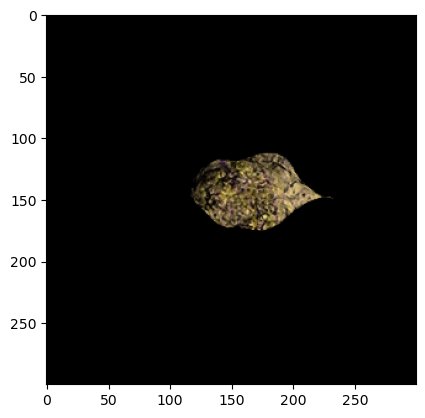

torch.Size([3, 300, 300])


In [39]:
# Inicialización de listas para almacenar características de distintas regiones y características combinadas
features_ICM = []  # Lista para características de la región ICM
features_TE = []   # Lista para características de la región TE
features_ZP = []   # Lista para características de la región ZP
all_features = []  # Lista para características combinadas de todas las regiones

# Iterar sobre los datos de imagen
for index in np.arange(1, 2):
    print(index)  # Imprimir índice del ciclo actual

    # Cargar imágenes de distintas regiones
    img_ICM = load_image('data/BlastsOnline/GT_ICM', index)
    img_TE = load_image('data/BlastsOnline/GT_TE', index)
    img_ZP = load_image('data/BlastsOnline/GT_ZP', index)
    img_Blast = load_image('data/BlastsOnline/Images', index)

    # Crear imágenes en formato RGB combinando distintas regiones con la imagen base
    rgb_ICM_segmented = np.stack((img_ICM * img_Blast,) * 3, axis=2)
    rgb_ICM_segmented_resized = resize(rgb_ICM_segmented, (300, 300, 3), anti_aliasing=True)
    rgb_TE_segmented = np.stack((img_TE * img_Blast,) * 3, axis=2)
    rgb_TE_segmented_resized = resize(rgb_TE_segmented, (300, 300, 3), anti_aliasing=True)
    rgb_ZP_segmented = np.stack((img_ZP * img_Blast,) * 3, axis=2)
    rgb_ZP_segmented_resized = resize(rgb_ZP_segmented, (300, 300, 3), anti_aliasing=True)
    # Imagen original RGB
    rgb = np.stack((img_Blast,) * 3, axis=2)
    rgb_resized = resize(rgb, (300, 300, 3), anti_aliasing=True)
    images_segmented = [rgb_resized, rgb_ICM_segmented_resized, rgb_ZP_segmented_resized, rgb_TE_segmented_resized]


    # Obtener embeddings de las imagenes segmentadas con las redes y transformarlos
    embeddings_ICM_segmented = obtener_embeddings_multi_redes(images_segmented[0], redes)[0]
    embeddings_ICM_segmented_reshaped = np.array(embeddings_ICM_segmented).reshape(-1)
    embeddings_TE_segmented = obtener_embeddings_multi_redes(images_segmented[1], redes)[0]
    embeddings_TE_segmented_reshaped = np.array(embeddings_TE_segmented).reshape(-1)
    embeddings_ZP_segmented = obtener_embeddings_multi_redes(images_segmented[2], redes)[0]
    embeddings_ZP_segmented_reshaped = np.array(embeddings_ZP_segmented).reshape(-1)
    embeddings_original= obtener_embeddings_multi_redes(images_segmented[3], redes)[0]
    embeddings_original_reshaped = np.array(embeddings_original).reshape(-1)


    # Obtener embeddings de las imagenes segmentadas con los autoencoders y concatenar todas las características
    tensor_Blast, _ = EmbryoDataset.__getitem__(index-1)
    plt.imshow(torch.swapaxes(tensor_Blast,0,2) * torch.tensor(rgb_ICM_segmented_resized))
    plt.show()
    tensor_Blast_ICM = torch.swapaxes(tensor_Blast,0,2) * torch.tensor(rgb_ICM_segmented_resized)
    tensor_Blast_TE = torch.swapaxes(tensor_Blast,0,2) * torch.tensor(rgb_TE_segmented_resized)
    tensor_Blast_ZP = torch.swapaxes(tensor_Blast,0,2) * torch.tensor(rgb_ZP_segmented_resized)
    print(torch.swapaxes(tensor_Blast_ICM,0,2).shape)

    autoencoder_embeddings = extract_encoded_features(autoencoder, tensor_Blast)
    autoencoder_embeddings_ICM = extract_encoded_features(autoencoder, torch.swapaxes(tensor_Blast_ICM,0,2))
    autoencoder_embeddings_TE = extract_encoded_features(autoencoder, torch.swapaxes(tensor_Blast_TE,0,2))
    autoencoder_embeddings_ZP = extract_encoded_features(autoencoder, torch.swapaxes(tensor_Blast_ZP,0,2))
    
    small_autoencoder_embeddings = extract_encoded_features(small_autoencoder, tensor_Blast)
    small_autoencoder_embeddings_ICM = extract_encoded_features(small_autoencoder, torch.swapaxes(tensor_Blast_ICM,0,2))
    small_autoencoder_embeddings_TE = extract_encoded_features(small_autoencoder, torch.swapaxes(tensor_Blast_TE,0,2))
    small_autoencoder_embeddings_ZP = extract_encoded_features(small_autoencoder, torch.swapaxes(tensor_Blast_ZP,0,2))


    total_embeddings = np.hstack((embeddings_ICM_segmented_reshaped,
                                  embeddings_TE_segmented_reshaped,
                                  embeddings_ZP_segmented_reshaped,
                                  autoencoder_embeddings,
                                  autoencoder_embeddings_ICM,
                                  autoencoder_embeddings_TE,
                                  autoencoder_embeddings_ZP,
                                  small_autoencoder_embeddings,
                                  small_autoencoder_embeddings_ICM,
                                  small_autoencoder_embeddings_TE,
                                  small_autoencoder_embeddings_ZP))
    
    ICM_embeddings = np.hstack((embeddings_ICM_segmented_reshaped,
                                  autoencoder_embeddings_ICM,
                                  small_autoencoder_embeddings_ICM))
    
    TE_embeddings = np.hstack((embeddings_TE_segmented_reshaped,
                                  autoencoder_embeddings_TE,
                                  small_autoencoder_embeddings_TE))

    ZP_embeddings = np.hstack((embeddings_ZP_segmented_reshaped,
                                  autoencoder_embeddings_ZP,
                                  small_autoencoder_embeddings_ZP))


    # Agregar las características a las listas respectivas
    features_ICM.append(ICM_embeddings)
    features_TE.append(TE_embeddings)
    features_ZP.append(ZP_embeddings)
    all_features.append(total_embeddings)


In [36]:
print(torch.swapaxes(tensor_Blast_ICM,0,2).shape)


torch.Size([3, 300, 300])


## Save features

In [14]:

# Convert NumPy arrays within lists to nested lists
features_ICM_list = [arr.tolist() for arr in features_ICM]
features_TE_list = [arr.tolist() for arr in features_TE]
features_ZP_list = [arr.tolist() for arr in features_ZP]
all_features_list = [arr.tolist() for arr in all_features]

# Save the nested lists in JSON files
with open('data/embedded_features/features_ICM.json', 'w') as archivo_json:
    json.dump(features_ICM_list, archivo_json)

with open('data/embedded_features/features_TE.json', 'w') as archivo_json:
    json.dump(features_TE_list, archivo_json)

with open('data/embedded_features/features_ZP.json', 'w') as archivo_json:
    json.dump(features_ZP_list, archivo_json)

with open('data/embedded_features/all_features.json', 'w') as archivo_json:
    json.dump(all_features_list, archivo_json)


# To load the data back
with open('data/embedded_features/features_ICM.json', 'r') as archivo:
    loaded_data = json.load(archivo)
    features_ICM = [np.array(arr) for arr in loaded_data]

with open('data/embedded_features/features_TE.json', 'r') as archivo:
    loaded_data = json.load(archivo)
    features_TE = [np.array(arr) for arr in loaded_data]

with open('data/embedded_features/features_ZP.json', 'r') as archivo:
    loaded_data = json.load(archivo)
    features_ZP = [np.array(arr) for arr in loaded_data]

with open('data/embedded_features/all_features.json', 'r') as archivo:
    loaded_data = json.load(archivo)
    all_features = [np.array(arr) for arr in loaded_data]

# 5) Entrenamiento

## Region to classify

In [15]:
# To train using all features
X,y = choose_region(region, n_data, all_features, blast_quality)

# To train using only region-specific features
X,y = choose_region(region, n_data, features_ICM, blast_quality)

191916


## Principal component analysis

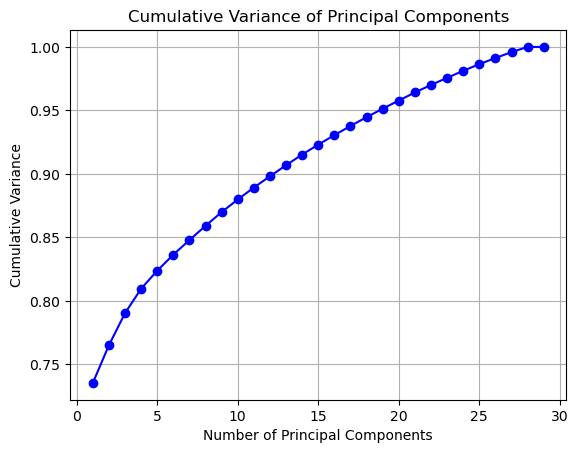

In [16]:
# Apply PCA for dimensionality reduction
X_pca = apply_PCA(X, n_data-1)

## Decision Tree

In [17]:
# Definir un espacio de búsqueda 

param_grid = {
    'max_depth': [None, 3, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 12],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3],
    'class_weight': [None, 'balanced']
}

param_grid = {
    'max_depth': [None, 3, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

param_grid = {
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

# Clasificador
clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Entrenamiento
output = run_halving_grid_search(X, y, clf, param_grid)

# Entrenamiento con dimensionalidad reducida
output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'max_depth': 3, 'min_samples_split': 2}

Mean Accuracy in cross-validation: 0.4833333333333333
Standard Deviation of Accuracy in cross-validation: 0.0


0it [00:00, ?it/s]

Best parameters: {'max_depth': 3, 'min_samples_split': 2}

Mean Accuracy in cross-validation: 0.5
Standard Deviation of Accuracy in cross-validation: 0.0


## Random Forest

In [18]:

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_samples': [None, 0.8, 0.9, 1.0],  # Solo para bootstrap=True
    'oob_score': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

param_grid = {
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

# Clasificador
clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Entrenamiento
output = run_halving_grid_search(X, y, clf, param_grid)

# Entrenamiento con dimensionalidad reducida
output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'max_depth': 3, 'min_samples_split': 2}

Mean Accuracy in cross-validation: 0.5833333333333333
Standard Deviation of Accuracy in cross-validation: 0.0


0it [00:00, ?it/s]

Best parameters: {'max_depth': 3, 'min_samples_split': 5}

Mean Accuracy in cross-validation: 0.5833333333333333
Standard Deviation of Accuracy in cross-validation: 0.04999999999999999


## SVM

In [19]:
# Definir el espacio de búsqueda

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 1e-3, 1e-4],
    'degree': [2, 3, 4],  # Solo para kernel 'poly'
    'coef0': [0.0, 0.1, 1.0]  # Solo para kernel 'poly' y 'sigmoid'
}

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

param_grid = {
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

# Clasificador
clf = SVC(class_weight='balanced', random_state=42)

# Entrenamiento
output = run_halving_grid_search(X, y, clf, param_grid)

# Entrenamiento con dimensionalidad reducida
output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'gamma': 'scale', 'kernel': 'linear'}

Mean Accuracy in cross-validation: 0.61
Standard Deviation of Accuracy in cross-validation: 0.08999999999999997


0it [00:00, ?it/s]

Best parameters: {'gamma': 'scale', 'kernel': 'linear'}

Mean Accuracy in cross-validation: 0.6633333333333333
Standard Deviation of Accuracy in cross-validation: 0.03666666666666668


## Naive bayes

In [20]:

# Definir el espacio de búsqueda
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

# Clasificador
clf = GaussianNB()

# Entrenamiento
output = run_halving_grid_search(X, y, clf, param_grid)

# Entrenamiento con dimensionalidad reducida
output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'var_smoothing': 0.01}

Mean Accuracy in cross-validation: 0.6733333333333333
Standard Deviation of Accuracy in cross-validation: 0.05385164807134505


0it [00:00, ?it/s]

Best parameters: {'var_smoothing': 0.1}

Mean Accuracy in cross-validation: 0.4416666666666666
Standard Deviation of Accuracy in cross-validation: 0.07274384280931728


## XGBoost

In [21]:

# Definir el espacio de búsqueda

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 1, 10],
}

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01,0.2],
}

# Clasificador 
clf = xgb.XGBClassifier(random_state=42)

# Entrenamiento
output = run_halving_grid_search(X, y, clf, param_grid)

# Entrenamiento con dimensionalidad reducida
output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'learning_rate': 0.01, 'max_depth': 3}

Mean Accuracy in cross-validation: 0.5333333333333333
Standard Deviation of Accuracy in cross-validation: 0.0


0it [00:00, ?it/s]

Best parameters: {'learning_rate': 0.01, 'max_depth': 3}

Mean Accuracy in cross-validation: 0.5333333333333333
Standard Deviation of Accuracy in cross-validation: 0.0
